In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..'))
from physics215ProjectCode import cosamp_fn


plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [2]:
def constructSyntheticSignal(n, f_a_orig, t_end=1):
    '''
    constructs a sine wave signal 
    n = number of data points to construct original signal
    if f_a_orig is 'int':
        wave of frequency f_a_orig has amplitude 1 
    if f_a_orig is 'list':
        wave of frequencies in f_a_orig will all have amplitude 1
    if f_a_orig is 'dict':
        wave of frequencies in the keys with value being the corresponding amplitude
        Ex. constructSyntheticSignal(4096, {3:1, 15:2}, t_end=1) #constructs 4096 sample points of 
        wave of frequency 3 with amplitude 1 and freq 15 with amp 2

    set t_end to 1 so that n is the sampling frequency
    '''
    if type(f_a_orig).__name__ == "int":
        t = np.linspace(0,t_end,n)
        x = np.cos(2 * f_a_orig * np.pi * t)
        xt = np.fft.fft(x) # Fourier transformed signal
        PSD = xt * np.conj(xt) / n # Power spectral density

        return x, PSD, t

    elif type(f_a_orig).__name__ == "list":
        x = 0
        t = np.linspace(0,t_end,n)
        for f in f_a_orig:
            x += np.cos(2 * f * np.pi * t)
            xt = np.fft.fft(x) # Fourier transformed signal
            PSD = xt * np.conj(xt) / n # Power spectral density

        return x, PSD, t

    elif type(f_a_orig).__name__ == "dict":
        x = 0
        t = np.linspace(0,t_end,n)
        for f in f_a_orig:
            x += f_a_orig[f]*np.cos(2 * f * np.pi * t)
            xt = np.fft.fft(x) # Fourier transformed signal
            PSD = xt * np.conj(xt) / n # Power spectral density

        return x, PSD, t


In [3]:
def reconstructSignal_dct(x, p, sparsity=10, epsilon=1.e-10,max_iter=10):
    '''
    x - original signal
    p - number of points to sample from the original signal
    
    implements signal reconstruction by Steve Brunton (Data Driven Science and Engineering)
    uses discrete cosine transform as basis function 
    '''

    n = len(x)
    perm = np.floor(np.random.rand(p) * n).astype(int)
    y = x[perm]
    ## Solve compressed sensing problem
    Psi = dct(np.identity(n)) # Build Psi
    Theta = Psi[perm,:]       # Measure rows of Psi
    
    s = cosamp_fn.cosamp(Theta,y,sparsity,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
    xrecon = idct(s) # reconstruct full signal

    PSD = xrecon * np.conj(xrecon) / n # Power spectral density

    return xrecon, PSD


def reconstructSignal_UniformSpacedSamples_dct(x, p, sparsity=10, epsilon=1.e-10,max_iter=10):
    '''
    x - original signal
    p - number of points to sample from the original signal
    
    implements signal reconstruction by sampling points at uniform spacing 
    (in this case, for accurate reconstruction, the sampling frequency must be 2 times the signal frequency)
    uses discrete cosine transform as basis function 
    '''

    n = len(x)
    perm = np.linspace(0, n-1, p).astype(int)
    y = x[perm]
    ## Solve compressed sensing problem
    Psi = dct(np.identity(n)) # Build Psi
    Theta = Psi[perm,:]       # Measure rows of Psi
    
    s = cosamp_fn.cosamp(Theta,y,sparsity,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
    xrecon = idct(s) # reconstruct full signal

    PSD = xrecon * np.conj(xrecon) / n # Power spectral density

    return xrecon, PSD
    

### Testing (Single Wave)

In [4]:
n = 4096 # points in high resolution signal
f_orig = 200
t_final = 1
t_start = 0
p_array = 400/2**np.arange(5)
p = 230 # num. random samples, p = n/32


x, PSD_orig, t = constructSyntheticSignal(n, f_orig, t_final)
x_recon, PSD_recon = reconstructSignal_dct(x, p)
x_recon_uni, PSD_recon_uni = reconstructSignal_UniformSpacedSamples_dct(x, p)

### Plotting

NameError: name 'freq' is not defined

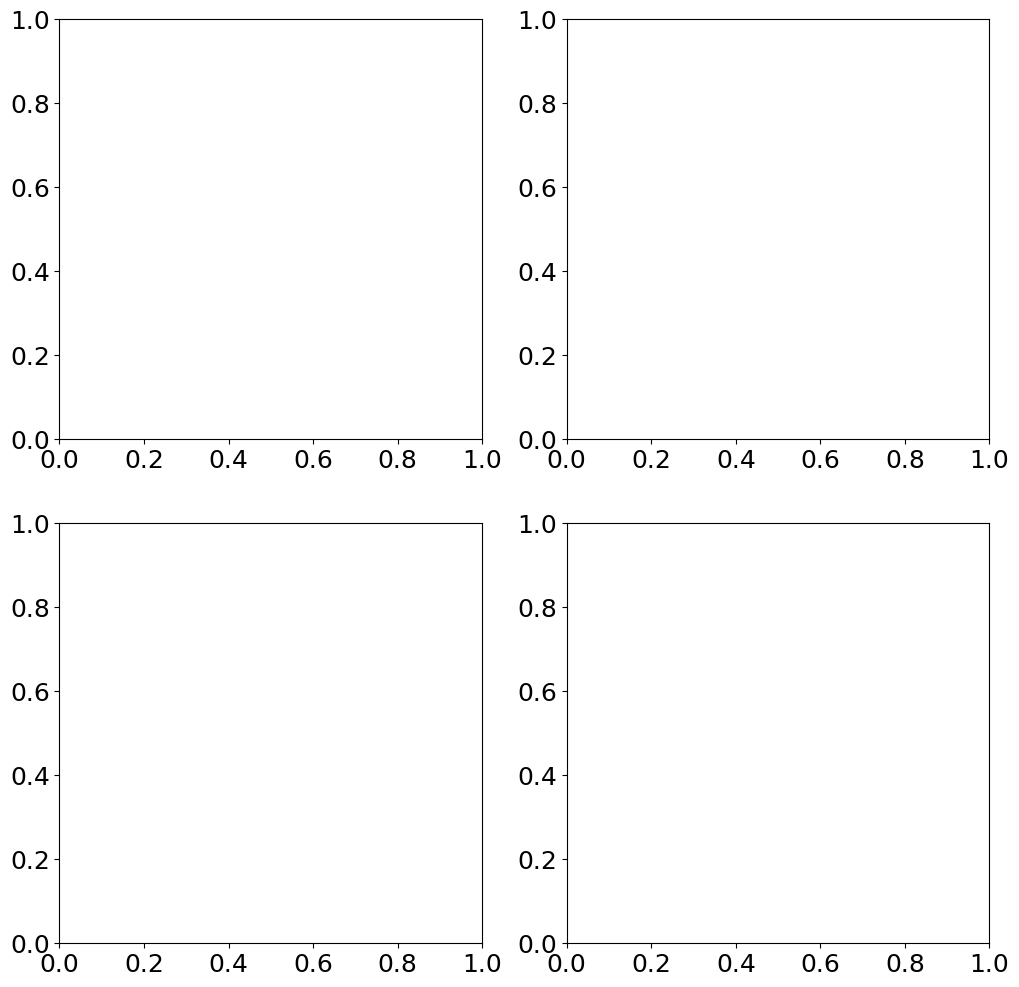

In [5]:
timeWindow = [2000, 3000]

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
xlim_r = 1024
ylim_u = 1200

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, xlim_r)
axs[1].set_ylim(0, ylim_u)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, xlim_r)
axs[3].set_ylim(0, ylim_u)

plt.show()